In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from tqdm import tqdm
import glob
import os
import time
from IPython.display import clear_output

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel

In [3]:
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
folder = 'C:/Users/oryan/Documents/mergers-in-cosmos'
student_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/followup-data'
results_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-results'
cosmos_folder = 'E:/cosmos-data'
fits_folder = 'E:/cosmos-fits'
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'

In [4]:
with fits.open(f'{cosmos_folder}/COSMOS2020_CLASSIC_R1_v2.1_p3.fits.gz') as hdul:
    data = hdul[1].data

In [5]:
df = pd.read_csv(f'{data_folder}/secondaries-identified.csv', index_col = 0).reset_index()

In [6]:
df_src = pd.read_csv(f'{data_folder}/cosmos-primary-data.csv', index_col = 0).reset_index().rename(columns = {'index' : 'SourceID'})[['SourceID', 'ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST']]

### Merging Sources

In [7]:
df_rename = df.rename(columns = {'index' : 'SourceID', '0' : 'merger'})

In [11]:
df_rename.merger.value_counts()

n      2186
y       755
nm      441
l       248
b       149
m         2
nn        1
nm.       1
nnm       1
n#        1
nbm       1
Name: merger, dtype: int64

In [12]:
df_merge = df_src.merge(df_rename, on = 'SourceID', how = 'left')

In [13]:
df_unknown = df_merge.query('merger == "b"')

In [14]:
df_unknown.head()

,SourceID,ID,ALPHA_J2000,DELTA_J2000,ez_z_phot,lp_zBEST,merger
6,4000705540005,1301817,149.722245,2.657243,0.399378,NaN,b
34,4000708110752,954293,150.119190,2.325494,0.160701,0.3828,b
271,4000749509721,973377,149.881132,2.340316,0.416074,0.4181,b
308,4000755600515,1448129,150.263259,2.801150,0.275345,NaN,b
399,4000767041112,792560,149.784560,2.172376,0.954910,0.9406,b


In [15]:
files = glob.glob(f'{fits_folder}/*.fits')

In [16]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [17]:
def getting_secondary(ra, dec, z, prim_id):
    record = data[(data['ALPHA_J2000'] > ra - (15 / (60*60))) & (data['ALPHA_J2000'] < ra + (15 / (60*60))) & (data['DELTA_J2000'] > dec - (15 / (60*60))) & (data['DELTA_J2000'] < dec + (15 / (60*60)))]
    
    df = Table(record).to_pandas()[['ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST']]
    
    df_z = (
        df
        .assign(redshift = df.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
        .drop(columns = ['ez_z_phot', 'lp_zBEST'])
        .dropna()
        .query('ID != @prim_id')
    )   
    
    return df_z

In [18]:
corr_prim_dict = {}

In [20]:
for counter, sourceid in enumerate(list(df_unknown.SourceID)):
    
    ra = df_unknown.query('SourceID == @sourceid')['ALPHA_J2000'].iloc[0]
    dec = df_unknown.query('SourceID == @sourceid')['DELTA_J2000'].iloc[0]
    z_ez = df_unknown.query('SourceID == @sourceid')['ez_z_phot'].iloc[0]
    z_lp = df_unknown.query('SourceID == @sourceid')['lp_zBEST'].iloc[0]
    id_str = df_unknown.query('SourceID == @sourceid')['ID'].iloc[0]
    
    redshift = picking_z(z_ez, z_lp)
    if redshift > 1.5:
        secondaries[sourceid] = 'l'
        continue
    
    prim_coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')
    
    df_secs = getting_secondary(ra, dec, z_ez, id_str)
    
    file = f'{fits_folder}/{sourceid}.fits'
    
    with fits.open(file) as hdul:
        im_data = hdul[0].data
        header = hdul[0].header
        
    print(im_data.shape)
    sys.exit()
    
    w = WCS(header)
        
    df_coords = (
        df_secs
        .assign(coords = df_secs.apply(lambda row: SkyCoord(ra = row.ALPHA_J2000 * u.deg, dec = row.DELTA_J2000 * u.deg, frame = 'fk5'), axis = 1))
    )
    
    id_list = list(df_coords.ID)
    coords_list = list(df_coords.coords)
    z_list = list(df_coords.redshift)
    
    pixs_list = []
    for j in coords_list:
        pixs_list.append(skycoord_to_pixel(j, w, origin = 0))
    pixs_arr = np.array(pixs_list)
    
    prim_pix = np.array(skycoord_to_pixel(prim_coord, w, origin = 0))
    
    fig, ax = plt.subplots(figsize = (8,8))
    ax.imshow(np.log10(im_data), origin = 'lower')
    ax.scatter(prim_pix[0], prim_pix[1], s = 10, color='black')
    ax.annotate(np.round(redshift, 3), (prim_pix[0], prim_pix[1]), color = 'black')
    ax.scatter(pixs_arr[:,0], pixs_arr[:,1], s = 10, color = 'red')
    for i, txt in enumerate(z_list):
        ax.annotate(f'{np.round(txt, 3)}, {i}', (pixs_arr[i,0], pixs_arr[i,1]), color = 'red')
    plt.show()
    
    if counter % 10 == 0:
        print(np.round(counter / len(files), 2))
    
    corr_prim_int = int(input('What is the correct primary?'))
    sec_identify = input('Does the secondary need to also be identified?')
    
    corr_prim_dict[sourceid] = {'prim_id' : id_list[corr_prim_int], 'sec_find' : sec_identify}
    
    clear_output(wait = True)

(1001, 1001)


SystemExit: 

In [124]:
df_secs = pd.DataFrame.from_dict(corr_prim_dict, orient = 'index')

In [125]:
df_secs.reset_index().rename(columns = {'index': 'SourceID'})

,SourceID,prim_id,sec_find
0,4000705540005,1307416,y
1,4000708110752,958323,y
2,4000749509721,977735,y
3,4000755600515,1452395,n
4,4000767041112,792252,y
...,...,...,...
144,6000536182869,723774,n
145,6000536185585,1317818,n
146,4000868140871,1044299,n
147,4001089801979,1045863,n


### Extracting Confirmed Values

In [126]:
df_conf = df_secs.query('sec_find == "n"').reset_index().rename(columns = {'index':'SourceID'}).drop(columns = 'sec_find')
df_conf

,SourceID,prim_id
0,4000755600515,1452395
1,4000812865165,1220435
2,4000828459485,1286844
3,4000830668768,1229007
4,4000858240266,726134
...,...,...
71,6000535866006,1176540
72,6000536182869,723774
73,6000536185585,1317818
74,4000868140871,1044299


In [127]:
def get_data(id_2020):
    row = data[data['ID'] == id_2020]
    
    if len(row) == 0.0:
        print('ID not found... Something went wrong!')
        sys.exit()
    
    sub_dict = {}
    for i in list(row.names):
        sub_dict[i] = row[i][0]
    
    return sub_dict

In [128]:
cosmos_dict = {}

In [129]:
done_ids = list(cosmos_dict.keys())
for i in tqdm(list(df_conf.SourceID)):
    id_2020 = df_conf.query('SourceID == @i').prim_id.iloc[0]
    cosmos_dict[i] = get_data(id_2020)

100%|██████████| 76/76 [00:33<00:00,  2.25it/s]


In [130]:
cosmos_df = pd.DataFrame.from_dict(cosmos_dict, orient = 'index')

In [82]:
# cosmos_df.to_csv(f'{combine_fold}/conf-replaced-prims.csv')

### Getting the Secondaries

In [75]:
df_unknown_red = df_secs.query('sec_find == "y"').reset_index().rename(columns = {'index' : 'SourceID'})
df_unknown_red

,SourceID,prim_id,sec_find
0,4000705540005,1307416,y
1,4000708110752,958323,y
2,4000749509721,977735,y
3,4000767041112,792252,y
4,4000812790810,510098,y
...,...,...,...
68,6000532943433,278133,y
69,6000534268277,1077922,y
70,6000534883422,743566,y
71,6000534884369,836010,y


In [84]:
replaced_dict = {}

In [86]:
done_ids = list(replaced_dict.keys())
for i in tqdm(list(df_unknown_red.SourceID)):
    id_2020 = df_unknown_red.query('SourceID == @i').prim_id.iloc[0]
    replaced_dict[i] = get_data(id_2020)

100%|██████████| 73/73 [00:36<00:00,  1.99it/s]


In [92]:
df_prims = pd.DataFrame.from_dict(replaced_dict, orient = 'index').reset_index().rename(columns = {'index' : 'SourceID'})

In [94]:
df_unknown_merged = df_unknown_red.merge(df_unknown, on = 'SourceID', how = 'left').drop(columns = ['sec_find', 'merger'])

In [100]:
sec_dict = {}

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log10


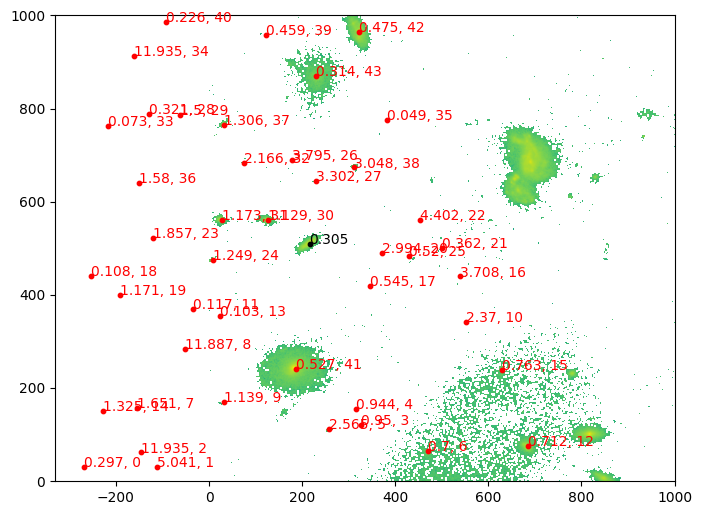

What number is the secondary 43


In [101]:
for counter, sourceid in enumerate(list(df_prims.SourceID)):
    
    ra = df_prims.query('SourceID == @sourceid')['ALPHA_J2000'].iloc[0]
    dec = df_prims.query('SourceID == @sourceid')['DELTA_J2000'].iloc[0]
    z_ez = df_prims.query('SourceID == @sourceid')['ez_z_phot'].iloc[0]
    z_lp = df_prims.query('SourceID == @sourceid')['lp_zBEST'].iloc[0]
    id_str = df_prims.query('SourceID == @sourceid')['ID'].iloc[0]
    
    redshift = picking_z(z_ez, z_lp)
    if redshift > 1.5:
        secondaries[sourceid] = 'l'
        continue
    
    prim_coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')
    
    df_secs = getting_secondary(ra, dec, z_ez, id_str)
    
    file = f'{fits_folder}/{sourceid}.fits'
    
    with fits.open(file) as hdul:
        im_data = hdul[0].data
        header = hdul[0].header
    
    w = WCS(header)
        
    df_coords = (
        df_secs
        .assign(coords = df_secs.apply(lambda row: SkyCoord(ra = row.ALPHA_J2000 * u.deg, dec = row.DELTA_J2000 * u.deg, frame = 'fk5'), axis = 1))
    )
    
    id_list = list(df_coords.ID)
    coords_list = list(df_coords.coords)
    z_list = list(df_coords.redshift)
    
    pixs_list = []
    for j in coords_list:
        pixs_list.append(skycoord_to_pixel(j, w, origin = 0))
    pixs_arr = np.array(pixs_list)
    
    prim_pix = np.array(skycoord_to_pixel(prim_coord, w, origin = 0))
    
    fig, ax = plt.subplots(figsize = (8,8))
    ax.imshow(np.log10(im_data), origin = 'lower')
    ax.scatter(prim_pix[0], prim_pix[1], s = 10, color='black')
    ax.annotate(np.round(redshift, 3), (prim_pix[0], prim_pix[1]), color = 'black')
    ax.scatter(pixs_arr[:,0], pixs_arr[:,1], s = 10, color = 'red')
    for i, txt in enumerate(z_list):
        ax.annotate(f'{np.round(txt, 3)}, {i}', (pixs_arr[i,0], pixs_arr[i,1]), color = 'red')
    plt.show()
    
    if counter % 10 == 0:
        print(np.round(counter / len(df_unknown_merged), 2))
        
    corr_sec_int = int(input('What number is the secondary'))
        
    sec_dict[sourceid] = {'sec_id' : id_list[corr_sec_int]}
    
    clear_output(wait = True)

In [110]:
sec_df = pd.DataFrame.from_dict(sec_dict, orient = 'index').reset_index().rename(columns = {'index' : 'SourceID'})

In [111]:
sec_df

,SourceID,sec_id
0,4175032695,352511
1,4575953945,1124323
2,4651333659,718770
3,4000705540005,1305894
4,4000708110752,959618
...,...,...
68,6000527423771,314642
69,6000532943433,276624
70,6000534268277,1077841
71,6000534883422,744769


In [112]:
secondaries = {}

In [113]:
done_ids = list(secondaries.keys())
for i in tqdm(list(sec_df.SourceID)):
    id_2020 = sec_df.query('SourceID == @i').sec_id.iloc[0]
    secondaries[i] = get_data(id_2020)

100%|██████████| 73/73 [00:36<00:00,  2.02it/s]


In [116]:
secs_full_df = (
    pd.DataFrame.from_dict(secondaries, orient = 'index').reset_index().rename(columns = {'index' : 'SourceID'})
)
secs_full_df

,SourceID,ID,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,FLUX_RADIUS,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4175032695,352511,150.178767,1.750506,21217.451172,11029.596680,0.000008,0.000007,-2.089392e-06,7.025870,...,-10.678155,-10.523099,-10.349973,-10.114880,-9.908020,0.703952,0.824684,0.933452,1.060671,1.161024
1,4575953945,1124323,149.687520,2.480424,32997.410156,28549.550781,0.000029,0.000035,-3.640113e-06,9.324339,...,-10.209988,-10.190275,-10.168399,-10.152209,-10.134642,0.018737,0.018737,0.018737,0.018737,0.018737
2,4651333659,718770,149.818503,2.102772,29858.400391,19484.841797,0.000033,0.000062,2.457396e-05,7.190663,...,-10.768190,-10.556565,-10.377059,-10.151812,-9.955298,1.477523,1.624478,1.760946,1.839990,1.884285
3,4000705540005,1305894,149.722207,2.660240,32164.496094,32865.136719,0.000127,0.000088,2.216449e-05,4.046546,...,-10.388170,-10.199575,-10.014665,-9.519182,-9.209780,0.360348,0.501035,0.581140,0.766053,0.970841
4,4000708110752,959618,150.119472,2.322125,22639.957031,24748.642578,0.000014,0.000026,-8.185635e-06,5.762374,...,-12.298839,-12.250489,-12.211298,-12.154972,-12.120248,0.202879,0.265820,0.327895,0.416642,0.463811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,6000527423771,314642,149.734871,1.719878,31866.630859,10295.350586,0.000015,0.000015,4.142404e-06,4.275614,...,-9.283077,-9.192872,-9.097071,-9.001945,-8.974356,0.318697,0.348787,0.395252,0.500847,0.551449
69,6000532943433,276624,149.847090,1.680858,29174.574219,9358.351562,0.000074,0.000052,1.413561e-05,4.989801,...,-9.250456,-9.165440,-9.090063,-8.704985,-8.395483,0.314333,0.365691,0.461705,0.566675,0.679982
70,6000534268277,1077841,150.550042,2.437917,12315.346680,27529.363281,0.000053,0.000061,-5.025846e-06,4.331073,...,-11.643023,-11.369270,-11.087677,-10.824616,-10.682006,0.206237,0.288263,0.390595,0.604408,0.705484
71,6000534883422,744769,150.206809,2.131860,20545.298828,20182.359375,0.000003,0.000012,-9.768541e-07,4.872496,...,-9.918005,-9.723744,-9.485485,-9.166856,-8.888946,0.797057,0.939237,1.078343,1.192184,1.331391


In [134]:
prims_only = cosmos_df.reset_index().rename(columns = {'index' : 'SourceID'})

In [135]:
prims_only

,SourceID,ID,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,FLUX_RADIUS,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000755600515,1452395,150.264326,2.801902,19167.421875,36264.050781,0.000014,0.000014,-2.348900e-06,7.432196,...,-10.264900,-10.213213,-10.157542,-10.124418,-10.093246,0.091685,0.157449,0.206736,0.266969,0.311510
1,4000812865165,1220435,150.055814,2.573339,24166.251953,30777.951172,0.000088,0.000050,1.488303e-07,6.051578,...,-10.878046,-10.799479,-10.642546,-10.380262,-10.272077,0.717030,0.786058,0.843624,0.897024,0.948232
2,4000828459485,1286844,150.562414,2.639952,12020.097656,32378.615234,0.000141,0.000095,2.540296e-05,6.709531,...,-10.280660,-10.205060,-9.689478,-9.282772,-9.035308,0.959131,1.086991,1.208977,1.422488,1.630747
3,4000830668768,1229007,150.529378,2.581113,12811.815430,30966.093750,0.000407,0.000301,-1.177180e-05,6.031314,...,-10.080538,-9.904918,-9.801511,-9.696353,-9.651797,0.360573,0.479115,0.610016,0.703553,0.771322
4,4000858240266,726134,150.248852,2.113332,19536.916016,19737.753906,0.000013,0.000012,-1.116837e-06,4.992626,...,-11.713489,-11.486925,-10.783702,-10.529206,-10.377808,0.598617,0.624999,0.692826,0.758600,0.811290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,6000535866006,1176540,150.523312,2.532933,12956.948242,29809.662109,0.000045,0.000035,1.607560e-06,4.839243,...,-10.132591,-9.826183,-9.421119,-9.100132,-8.982306,1.475896,1.595383,1.727277,1.911516,2.037849
72,6000536182869,723774,150.122621,2.110133,22564.406250,19660.835938,0.000076,0.000119,-3.040616e-05,6.778842,...,-9.878784,-9.751786,-9.401183,-8.928739,-8.813148,0.377153,0.456486,0.579084,0.737382,0.951511
73,6000536185585,1317818,150.485343,2.668006,13868.165039,33051.375000,0.000017,0.000022,1.395847e-06,6.811810,...,-10.105012,-9.976798,-9.830551,-9.774467,-9.727638,0.976047,1.021467,1.061157,1.111651,1.153012
74,4000868140871,1044299,150.495365,2.405066,13626.280273,26740.505859,0.000054,0.000040,-6.065675e-06,5.238370,...,-9.510642,-9.401780,-9.324926,-9.273881,-9.209040,0.049476,0.089286,0.129482,0.155363,0.190408


In [143]:
df_exp = pd.concat([prims_only, df_prims, secs_full_df])

In [144]:
df_exp

,SourceID,ID,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,FLUX_RADIUS,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000755600515,1452395,150.264326,2.801902,19167.421875,36264.050781,0.000014,0.000014,-2.348900e-06,7.432196,...,-10.264900,-10.213213,-10.157542,-10.124418,-10.093246,0.091685,0.157449,0.206736,0.266969,0.311510
1,4000812865165,1220435,150.055814,2.573339,24166.251953,30777.951172,0.000088,0.000050,1.488303e-07,6.051578,...,-10.878046,-10.799479,-10.642546,-10.380262,-10.272077,0.717030,0.786058,0.843624,0.897024,0.948232
2,4000828459485,1286844,150.562414,2.639952,12020.097656,32378.615234,0.000141,0.000095,2.540296e-05,6.709531,...,-10.280660,-10.205060,-9.689478,-9.282772,-9.035308,0.959131,1.086991,1.208977,1.422488,1.630747
3,4000830668768,1229007,150.529378,2.581113,12811.815430,30966.093750,0.000407,0.000301,-1.177180e-05,6.031314,...,-10.080538,-9.904918,-9.801511,-9.696353,-9.651797,0.360573,0.479115,0.610016,0.703553,0.771322
4,4000858240266,726134,150.248852,2.113332,19536.916016,19737.753906,0.000013,0.000012,-1.116837e-06,4.992626,...,-11.713489,-11.486925,-10.783702,-10.529206,-10.377808,0.598617,0.624999,0.692826,0.758600,0.811290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,6000527423771,314642,149.734871,1.719878,31866.630859,10295.350586,0.000015,0.000015,4.142404e-06,4.275614,...,-9.283077,-9.192872,-9.097071,-9.001945,-8.974356,0.318697,0.348787,0.395252,0.500847,0.551449
69,6000532943433,276624,149.847090,1.680858,29174.574219,9358.351562,0.000074,0.000052,1.413561e-05,4.989801,...,-9.250456,-9.165440,-9.090063,-8.704985,-8.395483,0.314333,0.365691,0.461705,0.566675,0.679982
70,6000534268277,1077841,150.550042,2.437917,12315.346680,27529.363281,0.000053,0.000061,-5.025846e-06,4.331073,...,-11.643023,-11.369270,-11.087677,-10.824616,-10.682006,0.206237,0.288263,0.390595,0.604408,0.705484
71,6000534883422,744769,150.206809,2.131860,20545.298828,20182.359375,0.000003,0.000012,-9.768541e-07,4.872496,...,-9.918005,-9.723744,-9.485485,-9.166856,-8.888946,0.797057,0.939237,1.078343,1.192184,1.331391


In [145]:
df_exp.to_csv(f'{combine_fold}/b-results-confirmed.csv')